In [1]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.sparse import csr_matrix

Load and preprocess data

In [2]:
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
train_path = 'aclImdb/test'
test_path = 'aclImdb/train'

train_texts = []
train_labels = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_path, label_type)
    for fname in os.listdir(dir_name):
        if fname.endswith('.txt'):
            with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                train_texts.append(f.read())
            if label_type == 'neg':
                train_labels.append(0)
            else:
                train_labels.append(1)

test_texts = []
test_labels = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_path, label_type)
    for fname in os.listdir(dir_name):
        if fname.endswith('.txt'):
            with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                test_texts.append(f.read())
            if label_type == 'neg':
                test_labels.append(0)
            else:
                test_labels.append(1)
train_texts = np.array(train_texts)
test_texts = np.array(test_texts)
vectorizer_train = CountVectorizer()
train_features_ = vectorizer_train.fit_transform(train_texts)
train_features =  train_features_.toarray()
train_labels =  np.array(train_labels)
vectorizer_test = CountVectorizer(vocabulary=vectorizer_train.vocabulary_)
test_features_ = vectorizer_test.fit_transform(test_texts)
test_features =  test_features_.toarray()
test_labels =  np.array(train_labels)

In [3]:

class NaiveBayes:
    def __init__(self,laplace_smoothing=1):
        self.prior = None
        self.likelihood = None
        self.laplace_smoothing = laplace_smoothing
    def fit(self, X, y):
        self.prior = np.zeros(2)
        self.likelihood = np.zeros((2, X.shape[1]))
        for label in [0, 1]:
            subset = X[y == label]
            self.prior[label] = subset.shape[0] / X.shape[0]
            self.likelihood[label, :] = (np.sum(subset, axis=0) + self.laplace_smoothing) / (np.sum(subset) + X.shape[1])
        return self
    def predict(self, X):
        yh = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            prediction = []
            for label in [0, 1]:
                likelihood_sum = np.sum(np.log(self.likelihood[label, x == 1]))
                prior_log = np.log(self.prior[label])
                prediction.append(prior_log + likelihood_sum)
            yh[i] = np.argmax(prediction)
        return yh
    
    def evaluate_acc(predicted, actual):
        return np.sum(actual == predicted)/predicted.shape[0]
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    def get_params(self, deep=True):
        return {'laplace_smoothing': self.laplace_smoothing}
    



Prediction for training set

In [5]:
gnb = NaiveBayes(laplace_smoothing=1.3)
a = gnb.fit(train_features, train_labels)
yh_train = a.predict(train_features)
print(gnb.evaluate_acc(yh_train, train_labels))

0.90364


Prediction for testing  set

In [6]:
yh_test = a.predict(test_features)
print(gnb.evaluate_acc(yh_test, test_labels))

0.83132


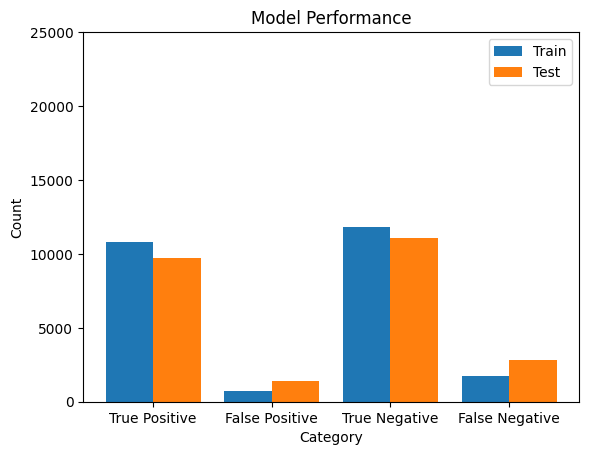

In [16]:
from sklearn.metrics import confusion_matrix
train_cm = confusion_matrix(train_labels, yh_train)
test_cm = confusion_matrix(test_labels, yh_test)
train_tn, train_fp, train_fn, train_tp = train_cm.ravel()
test_tn, test_fp, test_fn, test_tp = test_cm.ravel()
categories = ['True Positive', 'False Positive', 'True Negative', 'False Negative']
train_counts = [train_tp, train_fp, train_tn, train_fn]
test_counts = [test_tp, test_fp, test_tn, test_fn]
fig, ax = plt.subplots()
ax.bar(np.arange(len(categories)) - 0.4/2, train_counts, 0.4, label='Train')
ax.bar(np.arange(len(categories)) + 0.4/2, test_counts, 0.4, label='Test')
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories)
ax.set_title('Model Performance')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_ylim([0, max(train_cm.sum(), test_cm.sum())])
ax.legend()
plt.show()

Data cleaning experiments, remove words that only appear once and non relevant words

In [24]:
filter = np.sum(train_features, axis=0) < 2
train_features_filtered = train_features[:, ~filter]
vocabulary = [word for word, index in vectorizer_train.vocabulary_.items() if not filter[index]]
vectorizer_train_unfrequent = CountVectorizer(vocabulary=vocabulary)
train_features_unfrequent_ = vectorizer_train_unfrequent.fit_transform(train_texts)
vectorizer_test_unfrequent = CountVectorizer(vocabulary=vocabulary)
test_features_unfrequent_ = vectorizer_test_unfrequent.fit_transform(test_texts)
gnb = NaiveBayes(laplace_smoothing=1.3)
train_features_unfrequent_dense = train_features_unfrequent_.toarray()
test_features_unfrequent_dense = test_features_unfrequent_.toarray()
a = gnb.fit(train_features_unfrequent_dense, train_labels)
yh_u_train = a.predict(train_features_unfrequent_dense)
print(gnb.evaluate_acc(yh_u_train, train_labels))
yh_u_test = a.predict(test_features_unfrequent_dense)
print(gnb.evaluate_acc(yh_u_test, test_labels))


0.89364
0.83068


In [25]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
########Words that are not informative:
vectorizer_train_not_informative = CountVectorizer(stop_words=list(ENGLISH_STOP_WORDS))
train_features_ni_ = vectorizer_train_not_informative.fit_transform(train_texts)
train_features_ni =  train_features_ni_.toarray()
vectorizer_test_ni = CountVectorizer(vocabulary=vectorizer_train_not_informative.vocabulary_)
test_features_ni_ = vectorizer_test_ni.fit_transform(test_texts)
test_features_ni =  test_features_ni_.toarray()
gnb = NaiveBayes(laplace_smoothing=1.3)
a = gnb.fit(train_features_ni, train_labels)
yh_ni_train = a.predict(train_features_ni)
print(gnb.evaluate_acc(yh_ni_train, train_labels))
yh_ni_test = a.predict(test_features_ni)
print(gnb.gnb.evaluate_acc(yh_ni_test, test_labels))

0.91108
0.837


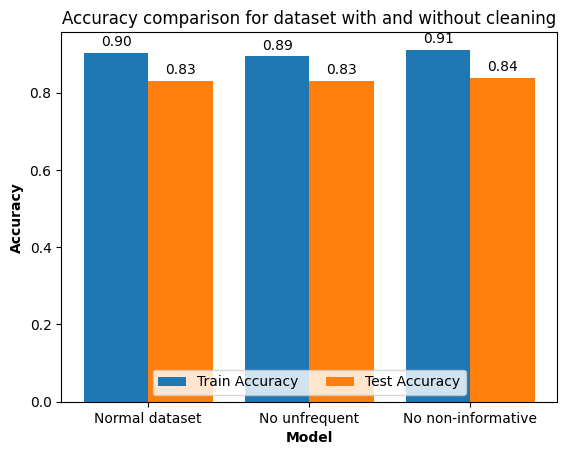

In [34]:
train_accuracies = [gnb.evaluate_acc(yh_train,train_labels), gnb.gnb.evaluate_acc(yh_u_train,train_labels), gnb.evaluate_acc(yh_ni_train,train_labels)]
test_accuracies = [gnb.evaluate_acc(yh_test,test_labels), gnb.evaluate_acc(yh_u_test,test_labels), gnb.evaluate_acc(yh_ni_test,test_labels)]
models = ['Normal dataset', 'No unfrequent', 'No non-informative']
bar_positions = np.arange(len(models))
bar_width = 0.40
fig, ax = plt.subplots()
train_bars = ax.bar(bar_positions - bar_width/2, train_accuracies, bar_width, label='Train Accuracy')
test_bars = ax.bar(bar_positions + bar_width/2, test_accuracies, bar_width, label='Test Accuracy')
ax.set_xticks(bar_positions)
ax.set_xticklabels(models)
for bar in train_bars + test_bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
ax.set_title('Accuracy comparison for dataset with and without cleaning')
ax.set_ylabel('Accuracy',weight='bold')
ax.set_xlabel('Model',weight='bold')
ax.legend(loc='lower center', ncol=2)
plt.show()

K- cross validation

In [35]:
from sklearn.model_selection import cross_val_score

smoothing_values = np.array([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])
scores = []
for smoothing in smoothing_values:
    nb = NaiveBayes(laplace_smoothing=smoothing)
    score = np.mean(cross_val_score(nb, train_features, train_labels, cv=5))
    scores.append(score)
best_smoothing = smoothing_values[np.argmax(scores)]


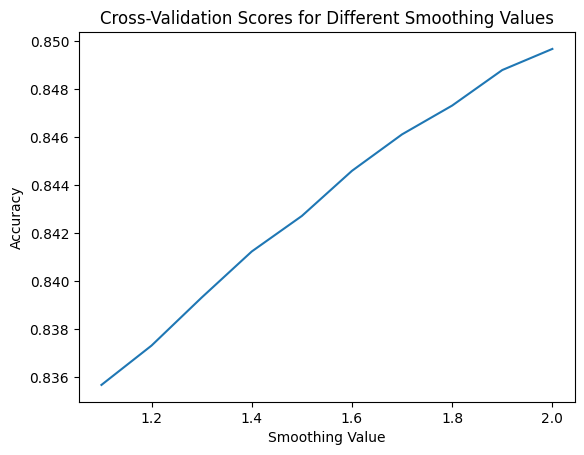

In [36]:
plt.plot(smoothing_values, scores)
plt.title('Cross-Validation Scores for Different Smoothing Values')
plt.xlabel('Smoothing Value')
plt.ylabel('Accuracy')
plt.show()